### Helpers

In [1]:
# %load_ext autoreload
# %autoreload 2

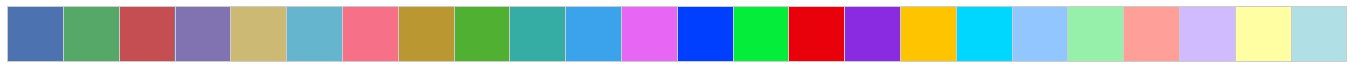

In [17]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
)
from pipeline import (
    split_classes, count_classes, sample,
    cross_validate, fit_predict_save, fit_save_model
)
from transformers.pca import pca_fit, pca_transform
from transformers.cosine import add_coses, to_degrees
from transformers.momentum import add_is_muon, add_is_muon_tight, add_probability_hit_detector
from transformers.err import add_mse, add_normed_err, err_cols

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [18]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + foi_cols
global_feature_importance = None
train, train_foi = read_train(used_cols, 1000000)
display(train.shape, count_classes(train))

(1000000, 63)

(421218, 578782)

Wall time: 7.22 s


In [22]:
%%time
closest_hits_filename = 'data/train_closest_hits_replaced.pkl'
closest_hits_filename = pd.read_pickle(closest_hits_filename).loc[:, xyz_cols + t_cols + dxyz_cols].copy()
closest_hits_filename.columns = cl_cols
print(closest_hits_filename.columns)

Index(['Cl_MatchedHit_X[0]', 'Cl_MatchedHit_X[1]', 'Cl_MatchedHit_X[2]',
       'Cl_MatchedHit_X[3]', 'Cl_MatchedHit_Y[0]', 'Cl_MatchedHit_Y[1]',
       'Cl_MatchedHit_Y[2]', 'Cl_MatchedHit_Y[3]', 'Cl_MatchedHit_Z[0]',
       'Cl_MatchedHit_Z[1]', 'Cl_MatchedHit_Z[2]', 'Cl_MatchedHit_Z[3]',
       'Cl_MatchedHit_T[0]', 'Cl_MatchedHit_T[1]', 'Cl_MatchedHit_T[2]',
       'Cl_MatchedHit_T[3]', 'Cl_MatchedHit_DX[0]', 'Cl_MatchedHit_DX[1]',
       'Cl_MatchedHit_DX[2]', 'Cl_MatchedHit_DX[3]', 'Cl_MatchedHit_DY[0]',
       'Cl_MatchedHit_DY[1]', 'Cl_MatchedHit_DY[2]', 'Cl_MatchedHit_DY[3]',
       'Cl_MatchedHit_DZ[0]', 'Cl_MatchedHit_DZ[1]', 'Cl_MatchedHit_DZ[2]',
       'Cl_MatchedHit_DZ[3]'],
      dtype='object')
Wall time: 3.15 s


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [63]:
closest_hits_filename = 'data/train_closest_hits_replaced.pkl'
dll_train = pd.read_pickle(closest_hits_filename)
display(dll_train.columns)

Index(['MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'Lextra_X[0]',
       'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]',
       'Lextra_Y[1]', 'Lextra_Y[2]', 'Lextra_Y[3]', 'label', 'weight',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DX[0]', 'MatchedHit_DX[1]',
       'MatchedHit_DX[2]', 'MatchedHit_DX[3]', 'MatchedHit_DY[0]',
       'MatchedHit_DY[1]', 'MatchedHit_DY[2]', 'MatchedHit_DY[3]',
       'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]',
       'MatchedHit_DZ[3]'],
      dtype='object')

In [ ]:
dll_train, _ = read_train(xy_cols + dx_cols + dy_cols + exy_cols, 10000000)

In [64]:
dll_train = add_mse(dll_train, [])

In [67]:
def create_pdfs(data):
    dts = [dt.loc[:, err_cols[0]] for dt in split_classes(data)]
    min_len = min(map(len, dts))
    nbins = int(round(np.sqrt(min_len) / np.pi))
    nbins = 230
    
    l, r = np.min(data[err_cols[0]]) - 1e-5, np.max(data[err_cols[0]]) + 1e-5
    k = 9
    m = (r - l) / k
    m = 20
    bins = np.concatenate((
        np.arange(l, 1, .02),
        np.arange(1, 3, .04),
        np.arange(3, 10, .1),
        np.arange(10, 16, .4),
        np.arange(16, 34, 1.),
        np.arange(34, 66, 2),
        np.arange(66, 120, 5.),
        np.linspace(120, r, 3),
    ))
    nbins = len(bins)
    print(nbins)
#     bins = np.concatenate((
#         np.linspace(l, m, (k-1) * nbins // k, endpoint=False), 
#         np.linspace(m, r, nbins // k)
#     ))
    pdfs = []
    
    for i in range(2):
        pdf, _ = np.histogram(dts[i], bins=bins)
        pdfs.append(pdf)
                       
    return pdfs, bins
                       
pdfs, bins = create_pdfs(dll_train)
# pdfs = pd.read_pickle('data/train_pdf.pkl')
# bins = pd.read_pickle('data/train_bins.pkl')

233


In [43]:
pdfs[0].save('data/train_pdf_0.pkl')
pdfs[1].to_pickle('data/train_pdf_1.pkl')
bins.to_pickle('data/train_bins.pkl')

AttributeError: 'numpy.ndarray' object has no attribute 'to_pickle'

In [68]:
pdfs

[array([1615, 5427, 7731, 8933, 8632, 8370, 8053, 7513, 7074, 6364, 5663,
        5036, 4595, 4208, 3827, 3539, 3277, 3067, 2741, 2694, 2510, 2415,
        2259, 2202, 2054, 2145, 1889, 1819, 1793, 1728, 1649, 1558, 1550,
        1480, 1394, 1356, 1294, 1333, 1229, 1310, 1088, 1186, 1150, 1101,
        1141, 1055, 1050,  916,  998,  871, 1840, 1785, 1734, 1641, 1623,
        1538, 1566, 1422, 1442, 1450, 1258, 1249, 1220, 1186, 1185, 1171,
        1133, 1123, 1129, 1035, 1022, 1090, 1012,  999,  994,  971,  972,
         934,  887,  893,  848,  862,  865,  789,  784,  768,  738,  762,
         761,  737,  747,  785,  705,  698,  714,  682,  637,  650,  620,
         675, 1633, 1565, 1504, 1386, 1413, 1415, 1382, 1363, 1225, 1288,
        1220, 1177, 1211, 1169, 1201, 1148, 1181, 1122, 1059, 1068, 1086,
        1068, 1034, 1017, 1031, 1050, 1034,  956,  983,  990,  991, 1037,
         973,  923,  922, 1025,  937,  900,  929,  979,  947,  883,  946,
         926,  905,  894,  927,  880, 

In [30]:
def add_dll(data, features):
    def get_probs(pdf, x):
        indices = np.digitize(x, bins) - 1
        wbin = (bins[indices + 1] - bins[indices]) / (np.max(bins) - np.min(bins))
        prob = pdf[indices] / pdf.sum()
        return prob #* wbin

    def get_dll(x):
        probs = [get_probs(pdf, x) for pdf in pdfs]
        DLL = np.log(probs[1]) - np.log(probs[0])
        return DLL

    data[err_cols[1]] = get_dll(data.loc[:, err_cols[0]])
    features += err_cols[1:2]
    return data

df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.779301,0.775794,0.877175,0.823341,0.810479,0.635964,0.101791
std,0.008540,0.010762,0.002849,0.005475,0.010079,0.033683,0.001622
min,0.771146,0.766443,0.874616,0.817856,0.799671,0.611698,0.100345
25%,0.774862,0.769912,0.875640,0.820608,0.805909,0.616736,0.100914
50%,0.778578,0.773381,0.876663,0.823360,0.812146,0.621775,0.101482
75%,0.783378,0.780469,0.878454,0.826084,0.815884,0.648097,0.102514
max,0.788179,0.787558,0.880246,0.828807,0.819621,0.674420,0.103545


In [31]:
import numpy as np
from common import x_cols, y_cols, z_cols

da_cols = ['DAngle[%d]' % i for i in range(1, 4)]

def add_coses(data, features):
    def get_layer_coords(data, i):
        return data[[x_cols[i], y_cols[i], z_cols[i]]].values
  
    def dot(x, y):
        return np.sum(x * y, axis=1, dtype=np.float32)
    
    def norm(x):
        return np.sqrt(dot(x, x))

    def get_cosine_dist(L1, L2, L1_norm, L2_norm):
        cosines = dot(L1, L2) / L1_norm / L2_norm
        return np.clip(cosines, -1., 1.)
    
    layers = np.array([get_layer_coords(data, i) for i in range(4)])
    layers[1:] -= layers[:3]
    layers[0] = get_zero_point(data)
    
    for i in range(3):
        cur_layer = layers[i]
        next_layer = layers[i+1]
        nan_mask = np.isnan(next_layer[:, 0])
        next_layer[nan_mask, :] = cur_layer[nan_mask, :]
        
        cosines = get_cosine_dist(cur_layer, next_layer, norm(cur_layer), norm(next_layer))
        degrees = to_degrees(cosines)
        cosines[nan_mask] = np.NaN
        degrees[nan_mask] = np.NaN
        data[da_cols[i]] = degrees
        
    features += da_cols
    return data

def to_degrees(cosine):
    return np.arccos(cosine) / np.pi * 180.

def _to_degrees(cosines):
    angles = cosines.copy()
    isn_mask = ~np.isnan(cosines)
    angles[isn_mask] = np.arccos(cosines[isn_mask]) / np.pi * 180.
    return angles

def get_zero_point(data):
    layers = [data[[ex_cols[i], ey_cols[i], z_cols[i]]].values for i in range(2)]
    d = layers[1] - layers[0]
    return d
    
df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.773700,0.766334,0.875368,0.817192,0.805867,0.716601,0.097206
std,0.008508,0.010853,0.002278,0.005218,0.012975,0.073104,0.003397
min,0.764247,0.754237,0.873832,0.811420,0.793256,0.665590,0.093386
25%,0.770179,0.761892,0.874059,0.815000,0.799213,0.674725,0.095865
50%,0.776110,0.769547,0.874286,0.818580,0.805169,0.683861,0.098343
75%,0.778427,0.772383,0.876136,0.820078,0.812173,0.742106,0.099116
max,0.780744,0.775219,0.877985,0.821577,0.819177,0.800352,0.099889


In [32]:
err_x_cols = ['Err_X[%i]' % i for i in range(N_STATIONS)]
err_y_cols = ['Err_Y[%i]' % i for i in range(N_STATIONS)]
err_z_cols = ['Err_Z[%i]' % i for i in range(N_STATIONS)]
err_xy_cols = err_x_cols + err_y_cols
err_xyz_cols = err_xy_cols + err_z_cols
ez = np.array([15270., 16470., 17670., 18870.])

def add_errs(data, features):
    for err_col, e_col, col in zip (err_xy_cols, exy_cols, xy_cols):
        data.loc[:, err_col] = data[e_col].values - data[col].values
        
    for i in range(4):
        data.loc[:, err_z_cols[i]] = ez[i] - data[z_cols[i]].values
    
    features += err_xyz_cols
    
df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=1000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.755964,0.750816,0.877914,0.809283,0.792902,0.606569,0.177735
std,0.020612,0.015559,0.026825,0.016964,0.023979,0.201943,0.004209
min,0.737952,0.739496,0.846939,0.792363,0.771496,0.381527,0.174004
25%,0.744724,0.741945,0.870170,0.800779,0.779946,0.523860,0.175453
50%,0.751497,0.744395,0.893401,0.809195,0.788395,0.666193,0.176903
75%,0.764970,0.756477,0.893401,0.817743,0.803605,0.719090,0.179600
max,0.778443,0.768559,0.893401,0.826291,0.818815,0.771986,0.182297


In [33]:
def add_mse(data, features):
#     dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
    xy_vals = data.loc[:, xy_cols].values

    dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
    D = np.nanmean(dxy**2, axis=1)
    
    data.loc[:, err_cols[0]] = D
    features += [err_cols[0]]
    return data

In [34]:
%%time
def sample(data, nrows):
    return data.iloc[np.random.permutation(len(data.index))[:nrows], :]

Wall time: 0 ns


In [61]:
hc_preimage_cols = xyz_cols + t_cols + dxyz_cols
hc_image_cols = foi_xyz_cols + foi_ts_cols[:1] + foi_dxyz_cols
seg_col = foi_ts_cols[2]
nrows = 10
train, train_foi = read_train(used_cols, nrows)

def fill_global_closest_matched_hits(data, data_foi):
    data_foi.astype({seg_col: np.int8}, copy=False)
    data_foi.set_index(['id', seg_col], inplace=True)
    
    join = data_foi.join(data.loc[:, exy_cols], how='right')
    display(join)
    for i in range(4):
        mask = join[seg_col] == i
        slc = join.loc[mask, ['id', foi_ts_cols[2], exy_cols[i], exy_cols[i+4], foi_xyz_cols[0], foi_xyz_cols[1]]]
        dx = slc.loc[:, exy_cols[i]].values - slc.loc[:, foi_xyz_cols[0]].values
        dy = slc.loc[:, exy_cols[i+4]].values - slc.loc[:, foi_xyz_cols[1]].values
        join.loc[mask, 'D2'] = dx**2 + dy**2
        
    res = join.sort_values(by=['id', foi_ts_cols[2], 'D2'])
    res = res.drop_duplicates(subset=['id', foi_ts_cols[2]])
        
    subcols = hc_image_cols
    nsubcols = len(subcols)
    for i, col in enumerate(cl_cols):
        mask = res[foi_ts_cols[2]] == (i % 4)
        indices = res.loc[mask, 'id']
        data.loc[indices, col] = res.loc[mask, subcols[i // 4]].values
    return data

global_foi_train_data = fill_global_closest_matched_hits(train, train_foi)
df_scores, feature_importance = cross_validate(train, n_estimators=20, n_splits=3, n_rows=nrows, transformer_cls=DataTransformer)
display(df_scores.describe())

FOI_hits_X   FOI_hits_Y    FOI_hits_Z  FOI_hits_DX  \
id FOI_hits_S                                                        
0  0.0        -2685.080078  1373.348145  15123.044922    25.500000   
   0.0        -2583.080078  1373.348145  15123.044922    25.500000   
   1.0        -2954.300049  1481.262207  16327.632812    27.500000   
   2.0        -3376.969971  1590.397461  17520.826172   118.000000   
   2.0        -3140.969971  1590.397461  17520.826172   118.000000   
   3.0        -3609.169922  1701.067627  18729.324219   126.000000   
1  0.0          739.549988  2387.722168  15212.597656    25.500000   
   1.0          852.510010  2575.974609  16420.576172    27.500000   
   2.0          827.000000  2764.196533  17614.853516   118.000000   
   3.0          758.719971  2952.103271  18824.429688   756.000000   
2  0.0        -1595.130005  -318.644745  15317.953125    12.750000   
   0.0         -681.580017  -222.241562  15117.298828    76.500000   
   1.0        -1775.949951  -344.529694  16522.060547    13.750000   
   1.0        -1761.949951  -207.129272  16405.554688    13.750000   
   1.0        -1748.449951  -344.529694  16522.060547    13.750000   
   1.0        -1734.449951  -207.129272  16405.554688    13.750000   
   1.0        -1603.949951   268.816986  16465.767578    20.750000   
   2.0        -1933.969971  -221.993256  17598.300781    59.000000   
   3.0        -2066.669922  -235.322327  18806.351562    63.000000   
3  0.0        -1708.829102  -191.404434  15201.410156    12.948485   
   0.0        -1708.432007   -65.005882  15201.865234    12.948485   
   1.0        -1816.949951  -207.129272  16405.554688    13.750000   
   2.0        -1933.969971  -221.993256  17598.300781    59.000000   
   3.0        -2066.669922  -235.322327  18806.351562    63.000000   
4  0.0        -1544.130005  1075.646240  15322.973633    12.750000   
   0.0        -1518.630005  1075.646240  15322.973633    12.750000   
   0.0        -1504.630005   941.448425  15205.489258    12.750000   
   1.0        -1651.949951  1014.662781  16409.953125    13.750000   
   2.0        -1815.969971  1089.198242  17603.021484    59.000000   
   3.0        -1940.670044  1165.168579  18811.394531    63.000000   

               FOI_hits_DY  FOI_hits_DZ  FOI_hits_T  FOI_hits_DT  Lextra_X[0]  \
id FOI_hits_S                                                                   
0  0.0          126.278549    33.954948         3.0          0.0 -2665.387939   
   0.0          126.278549    33.954948        11.0          8.0 -2665.387939   
   1.0          136.278488    33.990959         2.0          0.0 -2665.387939   
   2.0          146.278412    34.026966         7.0          0.0 -2665.387939   
   2.0          146.278412    34.026966         7.0          0.0 -2665.387939   
   3.0          156.278351    34.062977         5.0          0.0 -2665.387939   
1  0.0          126.278549    33.954948         9.0          1.0   765.309204   
   1.0          136.278488    33.990959        10.0         -1.0   765.309204   
   2.0          146.278412    34.026966         8.0          0.0   765.309204   
   3.0          156.278351    34.062977         4.0          4.0   765.309204   
2  0.0           63.078957    33.727364        10.0          0.0 -1590.582642   
   0.0           31.479162    33.613575         4.0          4.0 -1590.582642   
   1.0           68.078926    33.745369        13.0         10.0 -1590.582642   
   1.0           68.078926    33.745369        13.0          6.0 -1590.582642   
   1.0           68.078926    33.745369         3.0          0.0 -1590.582642   
   1.0           68.078926    33.745369         3.0         -4.0 -1590.582642   
   1.0          271.228271    92.005379        15.0         15.0 -1590.582642   
   2.0           73.078896    33.763374         3.0          0.0 -1590.582642   
   3.0           78.078857    33.781380         5.0          0.0 -1590.582642   
3  0.0           63.038589    33.727219         6.0          1.0 -1713.122

KeyError: 'FOI_hits_S'

In [62]:
%%time
from sklearn.base import TransformerMixin

def filter_unimportant_features(features):
    if global_feature_importance is None:
        return features
    fscore = global_feature_importance
    return [col for col in features if col not in fscore.index or fscore.loc[col, 'score'] > 0.01]
    return features

def replace_hits(data, features):
    global_foi_data = global_foi_train_data if train_cols[0] in data.columns else global_foi_test_data
    for col in cl_cols:
        data.loc[:, col[3:]] = global_foi_data.loc[data.index.values, col].values
    return data

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        features = [] + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + xyz_cols
        features = filter_unimportant_features(features)
        self.origin_features = features.copy()

#         add_cl_hits(data, features)
#         data = replace_hits(data, features)
        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
        add_dll(data, features)
        add_errs(data, features)
#         add_cl_mse(data, features)
        
#         filter_data(data)
        if not features:
            raise('no features')
    
        features = filter_unimportant_features(features)
        self.new_features = features[len(self.origin_features):]
        self.features = self.origin_features + self.new_features
        return data[features].values

df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

ValueError: Bug in code

### Test theory

In [44]:
%%time
df_scores, feature_importance = cross_validate(train, n_estimators=120, n_splits=5, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.790730,0.783562,0.881100,0.829472,0.823140,0.744303,0.086230
std,0.002623,0.002948,0.000506,0.001848,0.003734,0.016849,0.002175
min,0.787811,0.780404,0.880377,0.827381,0.818776,0.727549,0.083184
25%,0.788511,0.780898,0.880973,0.827965,0.820909,0.739188,0.085169
50%,0.791290,0.784294,0.881070,0.829827,0.823098,0.740986,0.086489
75%,0.791740,0.784663,0.881319,0.830187,0.824249,0.741075,0.087434
max,0.794300,0.787553,0.881762,0.831999,0.828666,0.772715,0.088875


Wall time: 1min 51s


In [47]:
sum(global_feature_importance.score > .01)

26

In [46]:
display(global_feature_importance)

,score
ErrMSE,0.129762
PT,0.084524
NShared,0.054762
DAngle[1],0.044048
NErr_X[0],0.041667
DAngle[2],0.034524
ncl[2],0.033333
P,0.032143
NErr_Y[3],0.029762
Mextra_DX2[3],0.028571


In [45]:
global_feature_importance = feature_importance.copy()

### Get result

In [50]:
test, test_foi = read_pub_test(used_cols)
global_foi_test_data = fill_global_closest_matched_hits(test.copy(), test_foi)

In [51]:
%%time
fit_predict_save(sample(train, 100000), test, "out/09_foi_closest_replaced_100.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 21.5 s


In [107]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_120.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 6min 57s


In [108]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_200.csv", n_estimators=200, transformer_cls=DataTransformer)

Wall time: 11min 39s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [139]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [5]:
from transformers.cosine import da_cols
from transformers.err import err_cols, nerr_xy_cols

In [11]:
from itertools import repeat
import os.path
import numpy as np
import pandas as pd
from common import (
    SIMPLE_FEATURE_COLS, ARR_FEATURE_COLS, ALL_TRAIN_COLS,
    xyz_cols, dxyz_cols, t_cols,
    foi_ts_cols, unused_train_cols, train_cols, hit_stats_cols, ncl_cols, hit_type_cols
)

class DatasetMetaData:
    def __init__(self, origin_csv_filenames, chunk_filenames_pattern, origin_col_set):
        self.origin_csv_filenames = origin_csv_filenames
        self.chunk_filenames_pattern = chunk_filenames_pattern
        self.origin_col_set = origin_col_set
        self.is_test = 'test_' in chunk_filenames_pattern

meta_train = DatasetMetaData(
    origin_csv_filenames=['data/train_part_1_v2.csv.gz', 'data/train_part_2_v2.csv.gz'],
    chunk_filenames_pattern='data/train_{label}_{group}_{ind:03d}.pkl',
    origin_col_set=SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS + ALL_TRAIN_COLS
)
meta_pub_test = DatasetMetaData(
    origin_csv_filenames=['data/test_public_v2.csv.gz'],
    chunk_filenames_pattern='data/test_pub_{group}_{ind:03d}.pkl',
    origin_col_set=SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS
)
meta_pvt_test = DatasetMetaData(
    origin_csv_filenames=[],
    chunk_filenames_pattern='data/test_pvt_{group}_{ind:03d}.pkl',
    origin_col_set=SIMPLE_FEATURE_COLS + ARR_FEATURE_COLS
)

col_groups = list(zip(['sf', 'af', 'tr'], [SIMPLE_FEATURE_COLS, ARR_FEATURE_COLS, ALL_TRAIN_COLS]))
label_prefixes = ['L0', 'L1']


class CsvDataReader:
    int_dtype = np.int32
    float_dtype = np.float32
    
    def __init__(self):
        self.na_values = ['-9999.0', '255']
    
    @staticmethod
    def get_read_stream(filenames, usecols, chunk_size=25000):
        return CsvDataReader()._get_read_stream(filenames, usecols, chunk_size)
    
    def _get_read_stream(self, filenames, usecols, chunk_size):
        if 'id' not in usecols:
            usecols += ['id']
            
        for filename in filenames:
            data_generator = pd.read_csv(
                filename, usecols=usecols, chunksize=chunk_size, index_col='id', #nrows=400000,
                na_values=self._get_na_values_dict(), keep_default_na=False,
                converters=self._get_converters(), dtype=self._get_types()
            )
            for data in data_generator:
                
                yield data

    def _get_na_values_dict(self):
        float_cols = [(col, '-9999.0') for col in xyz_cols + dxyz_cols]
        int_cols = [(col, '255') for col in t_cols]
        return {k:v for k, v in float_cols+int_cols}

    def _get_converters(self):
        def parse_float_array(line):
            arr = np.fromstring(line[1:-1], sep=" ", dtype=self.float_dtype)
            return arr

        converters = dict(zip(ARR_FEATURE_COLS, repeat(parse_float_array)))
        return converters
    
    def _get_types(self):
        types = dict(zip(SIMPLE_FEATURE_COLS + ALL_TRAIN_COLS, repeat(self.float_dtype)))
        for col in unused_train_cols[:1] + train_cols[:1] + hit_stats_cols + ncl_cols + hit_type_cols:
            types[col] = self.int_dtype
        types['id'] = self.int_dtype
        return types


class DataBuffer:
    def __init__(self):
        self._frames = []
    
    def append(self, frame):
        self._frames.append(frame)
    
    def cut(self, nrows):
        nrows = min(nrows, self.nrows)
        merged = self._merge_frames()
        head = merged.iloc[:nrows, :]
        tail = merged.iloc[nrows:, :]
        
        self._frames = [tail]
        return head, nrows
    
    def _merge_frames(self):
        if len(self._frames) > 1:
            merged = pd.concat(self._frames, axis=0, ignore_index=False)
            self._frames = [merged]
        return self._frames[0]
    
    @property
    def nrows(self):
        return sum([len(frame.index) for frame in self._frames])
    
    @property
    def is_empty(self):
        return self.nrows == 0


class DataTank:
    def __init__(self, max_volume, callback_on_full, early_stop=False):
        self._max_volume = max_volume
        self._buffer = DataBuffer()
        self._on_full = callback_on_full
        self._early_stop = early_stop
    
    def add(self, frame):
        if frame is None:
            return 0
        
        self._buffer.append(frame)
        flushed, flushed_vol = False, 0
        while self._is_full():
            flushed_vol += self.flush()
            flushed = True
            if self._early_stop:
                break
        return flushed, flushed_vol
        
    def flush(self):
        if self._buffer.is_empty:
            return 0
        flushed_data, flushed_vol = self._buffer.cut(self._max_volume)
        self._on_full(flushed_data)
        return flushed_vol
    
    def _is_full(self):
        return self._buffer.nrows >= self._max_volume


class TestDatasetHelper:
    def __init__(self, filename_pattern):
        self._filename_pattern = filename_pattern

    def filter_frame(self, frame):
        return frame
        
    def get_col_groups(self):
        return col_groups[:-1]

    def generate_chunk_filename(self, group_key, chunk_ind):
        return self._filename_pattern.format(group=group_key, ind=chunk_ind)


class TrainDatasetHelper:
    def __init__(self, filename_pattern, label, label_key):
        self._filename_pattern = filename_pattern
        self._label = label
        self._label_key = label_key

    def filter_frame(self, frame):
        return frame.loc[frame.label == self._label, :]

    def get_col_groups(self):
        return col_groups

    def generate_chunk_filename(self, group_key, chunk_ind):
        return self._filename_pattern.format(label=self._label_key, group=group_key, ind=chunk_ind)


class PickleDataWriter:
    def __init__(self, helper, chunk_size):
        self._helper = helper
        self._data_tank = DataTank(max_volume=chunk_size, callback_on_full=self._flush_chunk)
        self._chunk_index = 0
    
    def store(self, frame):
        filtered_frame = self._helper.filter_frame(frame)
        return self._data_tank.add(filtered_frame)
        
    def flush(self):
        return self._data_tank.flush()
    
    def _flush_chunk(self, chunk):
        self._store_chunk(chunk, self._chunk_index)
        self._chunk_index += 1
        
    def _store_chunk(self, chunk, chunk_index):
        for group_key, col_group in self._helper.get_col_groups():
            filename = self._helper.generate_chunk_filename(group_key, chunk_index)
            chunk.loc[:, col_group].to_pickle(filename)
            
            if group_key == 'af':
                filename = self._helper.generate_chunk_filename('afexp', chunk_index)
                self._expand(chunk, col_group).to_pickle(filename)
                
    @staticmethod
    def _expand(data, cols):
        ids = np.repeat(data.index.values, data['FOI_hits_N'].values)
        result = pd.DataFrame(data=ids, columns=['id'])
        for col in cols:
             result.loc[:, col] = np.hstack(data.loc[:, col])
        return result
    

class PickleDataReader:
    def __init__(self, helper, foi_expanded):
        self._helper = helper
        self._result = None
        self._foi_result = None
        self._foi_expanded = foi_expanded
        
    def read(self, nrows, cols):
        data_tank = DataTank(nrows, self._set_read_result, early_stop=True)
        foi_data_tank = DataTank(100000000, self._set_foi_read_result)
        
        for frame, foi_frame in self._read_chunks(cols):
            foi_data_tank.add(foi_frame)
            flushed, _ = data_tank.add(frame)
            if flushed:
                foi_data_tank.flush()
                return self._result, self._foi_result

        data_tank.flush()
        foi_data_tank.flush()
        return self._result, self._foi_result
        
    def _read_chunks(self, cols):
        chunk_index = 0
        while True:
            frame, foi_frame = self._read_chunk(chunk_index, cols)
            if frame is None:
                break
            
            yield frame, foi_frame
            chunk_index += 1
            
    def _set_read_result(self, data):
        self._result = data
        
    def _set_foi_read_result(self, data):
        self._foi_result = data
    
    def _read_chunk(self, chunk_index, cols):
        chunk_parts = []
        foi_dataframe = None        
        for group_key, col_group in self._helper.get_col_groups():
            cols_ = self._intersect_cols(cols, set(col_group))
            if not cols_:
                continue
            
            filename = self._helper.generate_chunk_filename(group_key, chunk_index)
            if not os.path.exists(filename):
                return None, None
            
            if group_key == 'af' and self._foi_expanded:
                filename = self._helper.generate_chunk_filename('afexp', chunk_index)
                foi_dataframe = pd.read_pickle(filename).loc[:, ['id'] + cols_]
                continue
            
            chunk_part = pd.read_pickle(filename).loc[:, cols_]
            chunk_parts.append(chunk_part)
            
        dataframe = pd.concat(chunk_parts, axis=1, sort=False)
        return dataframe, foi_dataframe
    
    @staticmethod
    def _intersect_cols(cols, col_subset):
        return [col for col in cols if col in col_subset]


class DatasetConverter:
    def __init__(self):
        self._stored = 0
                
    @staticmethod
    def convert(data_set_meta: DatasetMetaData, chunk_size=50000):
        dataframes_stream = CsvDataReader.get_read_stream(data_set_meta.origin_csv_filenames, data_set_meta.origin_col_set)
        
        filename_pattern = data_set_meta.chunk_filenames_pattern
        if data_set_meta.is_test:
            writers = [PickleDataWriter(TestDatasetHelper(filename_pattern), chunk_size)]
        else: 
            writers = [PickleDataWriter(TrainDatasetHelper(filename_pattern, i, label_prefixes[i]), chunk_size) for i in range(2)]
            
        DatasetConverter()._store_chunkified(dataframes_stream, writers)
        
    def _store_chunkified(self, dataframes_stream, writers):
        for data in dataframes_stream:
            for writer in writers:
                self._print_stored(writer.store(data))

        for writer in writers:
            self._print_stored(writer.flush())
            
    def _print_stored(self, stored):
        if stored == 0:
            return
        self._stored += stored
        if self._stored % 200000 == 0:
            print('Stored: {0}M'.format(self._stored / 1000000.))


class DatasetReader:
    @staticmethod
    def read_dataset(data_set_meta: DatasetMetaData, cols, nrows=None, prop_0=.5, foi_expanded=True):
        nrows = nrows if nrows is not None else 100000000
        filename_pattern = data_set_meta.chunk_filenames_pattern
        if data_set_meta.is_test:
            readers = [PickleDataReader(TestDatasetHelper(filename_pattern), foi_expanded=foi_expanded)]
            proportions = [nrows]
        else: 
            readers = [PickleDataReader(TrainDatasetHelper(filename_pattern, i, label_prefixes[i]), foi_expanded=foi_expanded) for i in range(2)]
            nrows0 = int(nrows * prop_0)
            proportions = [nrows0, nrows - nrows0]
            
        return DatasetReader()._read_dataset(readers, cols, proportions)
            
    def _read_dataset(self, readers, cols, proportions):
        data_parts = []
        foi_data_parts = []
        delta = 0
        col_delta = hit_stats_cols[:1] if hit_stats_cols[0] not in cols else []
        for reader, nrows in zip(readers, proportions):
            data_part, foi_data_part = reader.read(nrows + delta, cols + col_delta)
            if col_delta:
                data_part = data_part.drop(col_delta, axis=1)
            data_parts.append(data_part)
            if foi_data_part is not None:
                ind = self._find_slice(foi_data_part.loc[:, 'id'].values, nrows + delta)
                foi_data_part = foi_data_part.iloc[:ind, :]
                foi_data_parts.append(foi_data_part)
            delta = nrows - len(data_part.index)
            
        data = pd.concat(data_parts, axis=0, ignore_index=False)
        foi_data = pd.concat(foi_data_parts, axis=0, ignore_index=True) if foi_data_parts else None
        return data, foi_data
    
    @staticmethod
    def _find_slice(data, n):
        i, prev = 0, -1
        while i < len(data):
            if data[i] != prev:
                prev, n = data[i], n-1
            if n < 0:
                break
            i += 1
        return i
                
def convert_train():
    DatasetConverter.convert(meta_train)

def convert_pub_test():
    DatasetConverter.convert(meta_pub_test)
    
def convert_pvt_test():
    DatasetConverter.convert(meta_pvt_test)
    
def read_train(cols, rows, foi_expanded=True):
    return DatasetReader.read_dataset(meta_train, cols + train_cols, rows, foi_expanded=foi_expanded)

def read_pub_test(cols, foi_expanded=True):
    return DatasetReader.read_dataset(meta_pub_test, cols, foi_expanded=foi_expanded)

def read_pvt_test(cols, foi_expanded=True):
    return DatasetReader.read_dataset(meta_pvt_test, cols, foi_expanded=foi_expanded)

In [12]:
def to_closest_cols(cols):
    return ['Cl_' + col for col in cols]

cl_xyz_cols = to_closest_cols(xyz_cols)
cl_t_cols = to_closest_cols(t_cols)
cl_dxyz_cols = to_closest_cols(dxyz_cols)
cl_cols = cl_xyz_cols + cl_t_cols + cl_dxyz_cols

def fill_global_closest_matched_hits(data, data_foi):
    data.loc[:, 'id'] = data.index.values
    exy = data.loc[:, exy_cols]
    data_foi = data_foi.astype({foi_ts_cols[2]: np.int16})
    join = data_foi.join(exy, on='id', how='inner')
    for i in range(4):
        mask = join[foi_ts_cols[2]] == i
        slc = join.loc[mask, ['id', foi_ts_cols[2], exy_cols[i], exy_cols[i+4], foi_xyz_cols[0], foi_xyz_cols[1]]]
        dx = slc.loc[:, exy_cols[i]].values - slc.loc[:, foi_xyz_cols[0]].values
        dy = slc.loc[:, exy_cols[i+4]].values - slc.loc[:, foi_xyz_cols[1]].values
        join.loc[mask, 'D2'] = dx**2 + dy**2
        
    res = join.sort_values(by=['id', foi_ts_cols[2], 'D2'])
    res = res.drop_duplicates(subset=['id', foi_ts_cols[2]])
        
    subcols = foi_xyz_cols + foi_ts_cols[:1] + foi_dxyz_cols
    nsubcols = len(subcols)
    for i, col in enumerate(cl_cols):
        mask = res[foi_ts_cols[2]] == (i % 4)
        indices = res.loc[mask, 'id']
        data.loc[indices, col] = res.loc[mask, subcols[i // 4]].values
    return data

def add_cl_hits(data, features):
    for col in cl_cols:
        data.loc[:, col] = global_foi_data.loc[data.index.values, col].values        
    features += cl_cols
    return data

def add_cl_mse(data, features):
    dxy = (data.loc[:, cl_xyz_cols[:8]].values - data.loc[:, exy_cols].values) / data.loc[:, cl_dxyz_cols[:8]].values / 2.
    D = np.nanmean(dxy**2, axis=1)
    
    col = 'cl_' + err_cols[0]
    data.loc[:, col] = D
    features += [col]
    return data

In [14]:
%%time
dt, dt_foi = read_train(xyz_cols + exy_cols + ARR_FEATURE_COLS, 10000000)
global_foi_train_data = fill_global_closest_matched_hits(dt, dt_foi)

Wall time: 3min 59s


In [16]:
dt = replace_hits(dt, [])
display(dt.columns)
dt.to_pickle(closest_hits_filename)

Index(['MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'Lextra_X[0]',
       'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]',
       'Lextra_Y[1]', 'Lextra_Y[2]', 'Lextra_Y[3]', 'label', 'weight',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DX[0]', 'MatchedHit_DX[1]',
       'MatchedHit_DX[2]', 'MatchedHit_DX[3]', 'MatchedHit_DY[0]',
       'MatchedHit_DY[1]', 'MatchedHit_DY[2]', 'MatchedHit_DY[3]',
       'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]',
       'MatchedHit_DZ[3]'],
      dtype='object')

In [365]:
dt.loc[:, [err_cols[0], 'cl_' + err_cols[0]]].describe()

,ErrMSE,cl_ErrMSE
count,1000000.000000,1000000.000000
mean,5.427182,5.427182
std,12.111723,12.111723
min,0.002002,0.002002
25%,0.148033,0.148033
50%,0.400874,0.400874
75%,3.208471,3.208471
max,187.828674,187.828674
